<a href="https://colab.research.google.com/github/AndreaWang0723/jupyter/blob/master/w4_lab_vector_model_ans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W4 Lab Exercise
This is the lab exercise for MIS590: Information Retrieval. </br>
In this lab, you will gain the following experience:</br>
- Understand Vector Space Models (VSMs) for Information Retrieval.
- Develop Practical Skills in Vector-Based Document Representation, Including TF-IDF, Word2Vec, and BERT.
- Compare the Effectiveness of Different Term Weighting Schemes.
- Enhance Analytical Thinking in Evaluating IR Models
</br>

**Note:** When you see a pencil icon ✏️ in this notebook, it's time for you to code!

# 1. Preliminaries

## 1.1 Install and Import Libraries

In [ ]:
# Install the necessary packages
!pip install nltk
!pip install torch
!pip install numpy
!pip install gensim
!pip install string
!pip install transformers
!pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


In [ ]:
import math
import string
from collections import defaultdict

## 1.2 Input: Query & Document Collections (Corpus)

In [ ]:
query = "sleep deprivation"

corpus = [
    "Sleepless nights in the lab have become my new normal. I tried to fix the experiment setup, but the apparatus seems to have a mind of its own. My advisor says results are just around the corner, but the corner keeps moving. Coffee is my only true companion these days.",
    "I thought grad school would be intellectually stimulating, but it's mostly paperwork and waiting for emails. The departmental printer jammed again, and now I'm late for a meeting. The cafeteria ran out of the good snacks, so I'm surviving on vending machine chips. Sleep has become a luxury I can no longer afford.",
    "Writing the dissertation feels like climbing an endless mountain. Every time I finish a chapter, my supervisor suggests new revisions. The impostor syndrome is real, and I wonder if they made a mistake accepting me. Maybe I should have gone to clown college instead. I am utterly deprived of any semblance of a normal life.",
    "My research data got corrupted, and now I have to start over. The lab mouse escaped, and we spent hours trying to find it. The grant proposal deadline is tomorrow, and the online submission portal is down. At least my pet cactus hasn't died yet.",
    "The group meeting turned into a three-hour debate over font choices for the presentation. I'm pretty sure my colleague is stealing my lunch from the fridge. The photocopier is out to get me; it never works when I'm in a hurry. Is there a PhD in napping? Because I'd ace that.",
    "I haven't seen the sun in days due to endless coding sessions. The simulation keeps crashing, and Stack Overflow doesn't have the answers. My roommate thinks I'm a ghost haunting the apartment. Instant noodles have become my primary food group.",
    "Attending conferences sounded fun until I realized they involve a lot of awkward networking. I accidentally spilled coffee on a famous professor's shoes. My poster fell down twice during the session. Next time, I'll just send a cardboard cutout of myself.",
    "The university gym membership was supposed to keep me healthy, but I've only used it once. I tried to attend a yoga class after staying up late for a deadline, but I fell asleep during the meditation. Maybe instead of the gym, my bed is more essential for keeping me healthy.",
    "My teaching assistantship involves grading endless stacks of exams. Students keep emailing me for extensions with creative excuses. One claimed their dog sleeps on the laptop so they cannot use it for the exam. I was deprived of excuses for not completing my dissertation draft, and I might have got some good ones.",
    "Group projects are the worst when you're the only one doing the work. My team members are as elusive as Bigfoot. The project is due next week, and I haven't heard from them. Perhaps I should just write a paper on the sociological implications of group work avoidance."
]

# Binary labels for the documents' relevancy to the query
# Relevant ones: 1, 2, 5, 6, 8
corpus_relevancy_label = [1, 1, 0, 0, 1, 1, 0, 1, 0, 0]

In [ ]:
print(f"Query: {query}\n")
for idx, doc in enumerate(corpus):
    print(f"Document {idx+1}:\n{doc}\n")

Query: sleep deprivation

Document 1:
Sleepless nights in the lab have become my new normal. I tried to fix the experiment setup, but the apparatus seems to have a mind of its own. My advisor says results are just around the corner, but the corner keeps moving. Coffee is my only true companion these days.

Document 2:
I thought grad school would be intellectually stimulating, but it's mostly paperwork and waiting for emails. The departmental printer jammed again, and now I'm late for a meeting. The cafeteria ran out of the good snacks, so I'm surviving on vending machine chips. Sleep has become a luxury I can no longer afford.

Document 3:
Writing the dissertation feels like climbing an endless mountain. Every time I finish a chapter, my supervisor suggests new revisions. The impostor syndrome is real, and I wonder if they made a mistake accepting me. Maybe I should have gone to clown college instead. I am utterly deprived of any semblance of a normal life.

Document 4:
My research dat

# 2. Vector Space Model: TF-IDF

## 2.1 Data Preprocessing

### Steps for textual data preprocessing
1. Tokenization (= word segmentation)
2. Punctualtion and non-alphabetic token removal
3. Stopwords removal
4. Lemmatization / stemming

### Import libraries

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Initialize stopwords, lemmatizer, and punctuation list
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
punctuation_table = str.maketrans('', '', string.punctuation)

# We will use this sentence as example to showcase the different steps of data preprocessing
example_sentence = "The graduate student was typing, procrastinating, questioning herself, and finally submitting the dissertation while dreaming about sleep."
print(f"Example Sentence:\n{example_sentence}")

Example Sentence:
The graduate student was typing, procrastinating, questioning herself, and finally submitting the dissertation while dreaming about sleep.


### What is tokenization?

In [ ]:
tokens = word_tokenize(example_sentence.lower())
print(tokens)

['the', 'graduate', 'student', 'was', 'typing', ',', 'procrastinating', ',', 'questioning', 'herself', ',', 'and', 'finally', 'submitting', 'the', 'dissertation', 'while', 'dreaming', 'about', 'sleep', '.']


### A quick removal of punctualtions and non-alphabetic words

In [ ]:
tokens_noPunc = [word.translate(punctuation_table) for word in tokens if word.isalpha()]
print(tokens_noPunc)

['the', 'graduate', 'student', 'was', 'typing', 'procrastinating', 'questioning', 'herself', 'and', 'finally', 'submitting', 'the', 'dissertation', 'while', 'dreaming', 'about', 'sleep']


### What are stopwords?

In [ ]:
tokens_noSW = [word for word in tokens_noPunc if word not in stop_words]
print(tokens_noSW)

['graduate', 'student', 'typing', 'procrastinating', 'questioning', 'finally', 'submitting', 'dissertation', 'dreaming', 'sleep']


### What is lemmatization?

In [ ]:
print("Original\tLemmatized\n")

# Here we use pre-stopword removal tokens
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens_noSW]
for ori, lem in zip(tokens_noSW, lemmatized_tokens):
    print(f"{ori}\t{lem}")

Original	Lemmatized

graduate	graduate
student	student
typing	typing
procrastinating	procrastinating
questioning	questioning
finally	finally
submitting	submitting
dissertation	dissertation
dreaming	dreaming
sleep	sleep


### Observe the results above and discuss the following:
- What is lemmatization?
- I guess you cannot tell what lemmatization is from the results above. Let's try lemmatization in another way.

### How about we tell the lemmatizer more information of the tokens?

In [ ]:
# Part-of-Speech Tagging
tagged_tokens = pos_tag(tokens)
print(tagged_tokens)

[('the', 'DT'), ('graduate', 'NN'), ('student', 'NN'), ('was', 'VBD'), ('typing', 'VBG'), (',', ','), ('procrastinating', 'VBG'), (',', ','), ('questioning', 'VBG'), ('herself', 'PRP'), (',', ','), ('and', 'CC'), ('finally', 'RB'), ('submitting', 'VBG'), ('the', 'DT'), ('dissertation', 'NN'), ('while', 'IN'), ('dreaming', 'VBG'), ('about', 'RB'), ('sleep', 'NN'), ('.', '.')]


### Then we do the punctuation, non-alphabetic tokens, and stopword removal.

In [ ]:
# Remove punctuation and non-alphabetic tokens
tagged_tokens_noPunc = [(word[0].translate(punctuation_table), word[1]) for word in tagged_tokens if word[0].isalpha()]
print(tagged_tokens_noPunc)

# Remove stopwords
tagged_tokens_noSW = [(word[0], word[1]) for word in tagged_tokens_noPunc if word[0] not in stop_words]
print(tagged_tokens_noSW)

[('the', 'DT'), ('graduate', 'NN'), ('student', 'NN'), ('was', 'VBD'), ('typing', 'VBG'), ('procrastinating', 'VBG'), ('questioning', 'VBG'), ('herself', 'PRP'), ('and', 'CC'), ('finally', 'RB'), ('submitting', 'VBG'), ('the', 'DT'), ('dissertation', 'NN'), ('while', 'IN'), ('dreaming', 'VBG'), ('about', 'RB'), ('sleep', 'NN')]
[('graduate', 'NN'), ('student', 'NN'), ('typing', 'VBG'), ('procrastinating', 'VBG'), ('questioning', 'VBG'), ('finally', 'RB'), ('submitting', 'VBG'), ('dissertation', 'NN'), ('dreaming', 'VBG'), ('sleep', 'NN')]


### Take 2: what is lemmatization?

In [ ]:
# Convert treebank POS tags to wordnet POS tags so the lemmatizer can read them
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

print("Original\tLemmatized\n")
tagged_tokens_lemmatized = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens_noSW]
for ori, lem in zip(tagged_tokens_noSW, tagged_tokens_lemmatized):
    print(f"{ori[0]}\t{lem}")

Original	Lemmatized

graduate	graduate
student	student
typing	type
procrastinating	procrastinate
questioning	question
finally	finally
submitting	submit
dissertation	dissertation
dreaming	dream
sleep	sleep


### Observe the results above and discuss the following:
- What is lemmatization?

### What is stemming?

In [ ]:
print("Original\tStemmed\n")
tokens_stemmed = [stemmer.stem(word) for word in tagged_tokens_lemmatized]
for ori, stem in zip(tagged_tokens_lemmatized, tokens_stemmed):
    print(f"{ori}\t{stem}")

Original	Stemmed

graduate	graduat
student	student
type	type
procrastinate	procrastin
question	question
finally	final
submit	submit
dissertation	dissert
dream	dream
sleep	sleep


### Observe the results above and discuss the following:
- What is stemming?
- Why is stemming helpful in imporving TF-IDF performance?

### ✏️ Now let's preprocess the query and the documents!

In [ ]:
# TODO
# Preprocessing function
def preprocess_text(text):

    # Step 1: # Convert to lowercase and tokenize text into words
    tokens = word_tokenize(text.lower())

    # Step 2: Tag part-of-speech of the tokens
    tokens = pos_tag(tokens)

    # Step 3: Remove punctuation and non-alphabetic tokens
    tokens = [(word[0].translate(punctuation_table), word[1]) for word in tokens if word[0].isalpha()]

    # Step 4: Remove stopwords
    tokens = [(word[0], word[1]) for word in tokens if word[0] not in stop_words]

    # Step 5: Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tokens]

    # Step 6: Stem tokens
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

In [ ]:
# Apply preprocessing to each document in the corpus
preprocessed_query = preprocess_text(query)
print(f"Query: {preprocessed_query}\n")

preprocessed_corpus = [preprocess_text(doc) for doc in corpus]
# Print preprocessed corpus
for idx, doc in enumerate(preprocessed_corpus):
    print(f"Document {idx+1}: {doc}")

Query: ['sleep', 'depriv']

Document 1: ['sleepless', 'night', 'lab', 'becom', 'new', 'normal', 'tri', 'fix', 'experi', 'setup', 'apparatu', 'seem', 'mind', 'advisor', 'say', 'result', 'around', 'corner', 'corner', 'keep', 'move', 'coffe', 'true', 'companion', 'day']
Document 2: ['think', 'grad', 'school', 'would', 'intellectu', 'stimul', 'mostli', 'paperwork', 'wait', 'email', 'department', 'printer', 'jam', 'late', 'meet', 'cafeteria', 'run', 'good', 'snack', 'surviv', 'vend', 'machin', 'chip', 'sleep', 'becom', 'luxuri', 'longer', 'afford']
Document 3: ['write', 'dissert', 'feel', 'like', 'climb', 'endless', 'mountain', 'everi', 'time', 'finish', 'chapter', 'supervisor', 'suggest', 'new', 'revis', 'impostor', 'syndrom', 'real', 'wonder', 'make', 'mistak', 'accept', 'mayb', 'go', 'clown', 'colleg', 'instead', 'utterli', 'depriv', 'semblanc', 'normal', 'life']
Document 4: ['research', 'data', 'get', 'corrupt', 'start', 'lab', 'mous', 'escap', 'spend', 'hour', 'tri', 'find', 'grant', '

## ✏️ 2.2 Compute Term Frequency (TF)

In [ ]:
# Function to compute term frequency (TF) for each document
def compute_tf(doc):

    # Initialize the TF dictionary
    tf_dict = {}

    # TODO
    # Count the term frequency
    for word in doc:
        tf_dict[word] = tf_dict.get(word, 0) + 1

    # TODO
    # Divide term counts by total number of terms in the document
    total_terms = len(doc)
    for word in tf_dict:
        tf_dict[word] = tf_dict[word] / total_terms

    return tf_dict

# Compute TF for each document in the corpus
tf_corpus = [compute_tf(doc) for doc in preprocessed_corpus]

# Print TF values for each document
for idx, tf in enumerate(tf_corpus):
    print(f"TF for Document {idx+1}: {tf}\n")

TF for Document 1: {'sleepless': 0.04, 'night': 0.04, 'lab': 0.04, 'becom': 0.04, 'new': 0.04, 'normal': 0.04, 'tri': 0.04, 'fix': 0.04, 'experi': 0.04, 'setup': 0.04, 'apparatu': 0.04, 'seem': 0.04, 'mind': 0.04, 'advisor': 0.04, 'say': 0.04, 'result': 0.04, 'around': 0.04, 'corner': 0.08, 'keep': 0.04, 'move': 0.04, 'coffe': 0.04, 'true': 0.04, 'companion': 0.04, 'day': 0.04}

TF for Document 2: {'think': 0.03571428571428571, 'grad': 0.03571428571428571, 'school': 0.03571428571428571, 'would': 0.03571428571428571, 'intellectu': 0.03571428571428571, 'stimul': 0.03571428571428571, 'mostli': 0.03571428571428571, 'paperwork': 0.03571428571428571, 'wait': 0.03571428571428571, 'email': 0.03571428571428571, 'department': 0.03571428571428571, 'printer': 0.03571428571428571, 'jam': 0.03571428571428571, 'late': 0.03571428571428571, 'meet': 0.03571428571428571, 'cafeteria': 0.03571428571428571, 'run': 0.03571428571428571, 'good': 0.03571428571428571, 'snack': 0.03571428571428571, 'surviv': 0.03

## ✏️ 2.3 Compute Inverse Document Frequency (IDF)

In [ ]:
# Function to compute inverse document frequency (IDF) for each term in the corpus
def compute_idf(corpus):

    N = len(corpus)  # Total number of documents

    # Initialize the IDF dictionary
    idf_dict = defaultdict(int)

    # TODO
    # Count the number of documents containing each word
    for doc in corpus:
        for word in set(doc):  # Use set to count each word only once per document
            idf_dict[word] += 1

    #TODO
    # Compute IDF (logarithmic scale)
    for word in idf_dict:
        idf_dict[word] = math.log(N / (idf_dict[word])) + 1  # Smoothing by adding 1

    return idf_dict

# Compute IDF for the corpus
idf_dict = compute_idf(preprocessed_corpus)

# Print IDF values
print("IDF for Corpus:")
for word, idf in idf_dict.items():
    print(f"{word}: {idf}")

IDF for Corpus:
apparatu: 3.302585092994046
mind: 3.302585092994046
keep: 1.916290731874155
new: 2.6094379124341005
move: 3.302585092994046
around: 3.302585092994046
sleepless: 3.302585092994046
corner: 3.302585092994046
advisor: 3.302585092994046
normal: 2.6094379124341005
day: 2.6094379124341005
becom: 2.203972804325936
fix: 3.302585092994046
experi: 3.302585092994046
lab: 2.6094379124341005
companion: 3.302585092994046
seem: 3.302585092994046
true: 3.302585092994046
coffe: 2.6094379124341005
say: 3.302585092994046
tri: 2.203972804325936
night: 3.302585092994046
result: 3.302585092994046
setup: 3.302585092994046
late: 2.6094379124341005
vend: 3.302585092994046
department: 3.302585092994046
wait: 3.302585092994046
would: 3.302585092994046
run: 3.302585092994046
email: 2.6094379124341005
think: 2.6094379124341005
printer: 3.302585092994046
stimul: 3.302585092994046
surviv: 3.302585092994046
meet: 2.6094379124341005
snack: 3.302585092994046
paperwork: 3.302585092994046
afford: 3.3025850

## ✏️ 2.4 Compute TF-IDF

In [ ]:
# Function to compute TF-IDF for a document
def compute_tfidf(tf_doc, idf_dict):

    # Initialize TF-IDF dictionary
    tfidf_dict = {}

    # TODO
    # Multiply TF by corresponding IDF
    for word, tf_value in tf_doc.items():
        tfidf_dict[word] = tf_value * idf_dict.get(word, 0)  # Multiply TF by corresponding IDF

    return tfidf_dict

# Compute TF-IDF for each document in the corpus
tfidf_corpus = [compute_tfidf(tf, idf_dict) for tf in tf_corpus]

# Print TF-IDF values for each document
for idx, tfidf in enumerate(tfidf_corpus):
    print(f"TF-IDF for Document {idx+1}: {tfidf}\n")


TF-IDF for Document 1: {'sleepless': 0.13210340371976184, 'night': 0.13210340371976184, 'lab': 0.10437751649736403, 'becom': 0.08815891217303744, 'new': 0.10437751649736403, 'normal': 0.10437751649736403, 'tri': 0.08815891217303744, 'fix': 0.13210340371976184, 'experi': 0.13210340371976184, 'setup': 0.13210340371976184, 'apparatu': 0.13210340371976184, 'seem': 0.13210340371976184, 'mind': 0.13210340371976184, 'advisor': 0.13210340371976184, 'say': 0.13210340371976184, 'result': 0.13210340371976184, 'around': 0.13210340371976184, 'corner': 0.2642068074395237, 'keep': 0.0766516292749662, 'move': 0.13210340371976184, 'coffe': 0.10437751649736403, 'true': 0.13210340371976184, 'companion': 0.13210340371976184, 'day': 0.10437751649736403}

TF-IDF for Document 2: {'think': 0.09319421115836073, 'grad': 0.1179494676069302, 'school': 0.1179494676069302, 'would': 0.1179494676069302, 'intellectu': 0.1179494676069302, 'stimul': 0.1179494676069302, 'mostli': 0.1179494676069302, 'paperwork': 0.117949

## 2.5 The Implementaion of Information Retrieval System

### Measuring similarity: cosine similarity

In [ ]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    dot_product = sum(vec1.get(word, 0) * vec2.get(word, 0) for word in vec1)
    magnitude1 = math.sqrt(sum([value ** 2 for value in vec1.values()]))
    magnitude2 = math.sqrt(sum([value ** 2 for value in vec2.values()]))

    if not magnitude1 or not magnitude2:
        return 0.0
    return dot_product / (magnitude1 * magnitude2)

### Rank the documents using cosine similarity

In [ ]:
# Compute TF for the query
tf_query = compute_tf(preprocessed_query)

# Compute TF-IDF for the query
tfidf_query = compute_tfidf(tf_query, idf_dict)

# Compute the cosine similarity of each documents to the query
rankings = []
for idx, tfidf_doc in enumerate(tfidf_corpus):
    score = cosine_similarity(tfidf_doc, tfidf_query)
    rankings.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_tfidf = sorted(rankings, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on Query:")
for rank, (doc_idx, score) in enumerate(rankings, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")


Document Rankings based on Query:
Rank 1: Document 1 with score 0.0
Rank 2: Document 2 with score 0.11131520312033671
Rank 3: Document 3 with score 0.10476487421443352
Rank 4: Document 4 with score 0.0
Rank 5: Document 5 with score 0.0
Rank 6: Document 6 with score 0.0
Rank 7: Document 7 with score 0.0
Rank 8: Document 8 with score 0.0
Rank 9: Document 9 with score 0.20850879673278558
Rank 10: Document 10 with score 0.0


### Observe the results above and discuss the following:
- Are the highly ranked documents relevant to the query?
- Why?

# 3. Vector Space Model: Word2Vec

## 3.1 Import Libraries

In [ ]:
import numpy as np
import gensim.downloader as api
from gensim.models import Word2Vec

## 3.2 Load Pre-trained Word2Vec Model

In [ ]:
# Load the pre-trained Google News Word2Vec model
# This might take a while
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


### Let's observe a Word2Vec vector

In [ ]:
model['apple']

array([-0.06445312, -0.16015625, -0.01208496,  0.13476562, -0.22949219,
        0.16210938,  0.3046875 , -0.1796875 , -0.12109375,  0.25390625,
       -0.01428223, -0.06396484, -0.08056641, -0.05688477, -0.19628906,
        0.2890625 , -0.05151367,  0.14257812, -0.10498047, -0.04736328,
       -0.34765625,  0.35742188,  0.265625  ,  0.00188446, -0.01586914,
        0.00195312, -0.35546875,  0.22167969,  0.05761719,  0.15917969,
        0.08691406, -0.0267334 , -0.04785156,  0.23925781, -0.05981445,
        0.0378418 ,  0.17382812, -0.41796875,  0.2890625 ,  0.32617188,
        0.02429199, -0.01647949, -0.06494141, -0.08886719,  0.07666016,
       -0.15136719,  0.05249023, -0.04199219, -0.05419922,  0.00108337,
       -0.20117188,  0.12304688,  0.09228516,  0.10449219, -0.00408936,
       -0.04199219,  0.01409912, -0.02111816, -0.13476562, -0.24316406,
        0.16015625, -0.06689453, -0.08984375, -0.07177734, -0.00595093,
       -0.00482178, -0.00089264, -0.30664062, -0.0625    ,  0.07

### Observe the results above and discuss the following:
- What is the data type of this vector?
- What is the dimensionality?

### Finding analogies using Word2Vec

In [ ]:
model.most_similar("apple")

[('apples', 0.720359742641449),
 ('pear', 0.6450697183609009),
 ('fruit', 0.6410146355628967),
 ('berry', 0.6302295327186584),
 ('pears', 0.613396167755127),
 ('strawberry', 0.6058260798454285),
 ('peach', 0.6025872826576233),
 ('potato', 0.5960935354232788),
 ('grape', 0.5935863852500916),
 ('blueberry', 0.5866668224334717)]

In [ ]:
model.most_similar("Apple")

[('Apple_AAPL', 0.7456986308097839),
 ('Apple_Nasdaq_AAPL', 0.7300410270690918),
 ('Apple_NASDAQ_AAPL', 0.717508852481842),
 ('Apple_Computer', 0.7145972847938538),
 ('iPhone', 0.6924266219139099),
 ('Apple_NSDQ_AAPL', 0.6868603229522705),
 ('Steve_Jobs', 0.6758421659469604),
 ('iPad', 0.6580768823623657),
 ('Apple_nasdaq_AAPL', 0.6444970369338989),
 ('AAPL_PriceWatch_Alert', 0.6439753174781799)]

In [ ]:
model.most_similar(positive=['Gates', 'Apple'], negative=['Jobs'])

[('Microsoft', 0.457754522562027),
 ('Steve_Ballmer', 0.42643362283706665),
 ('Robert_Gates', 0.40924885869026184),
 ('Ballmer', 0.40724438428878784),
 ('Mullen', 0.4004097878932953),
 ('Chief_Executive_Steve_Ballmer', 0.3993479311466217),
 ('BlackBerry_maker', 0.39889541268348694),
 ('Apple_Nasdaq_AAPL', 0.39581313729286194),
 ('REDMOND_Wash._Microsoft', 0.3908952474594116),
 ('McAfee', 0.38951441645622253)]

## 3.3 Compute Word2Vec Embeddings

In [ ]:
# Notice here we only tokenize and lowercase the tokens:
tokens = [word_tokenize(doc.lower()) for doc in corpus]
query_tokens = word_tokenize(query.lower())

# Function to compute the average word vector for a document or query
def compute_avg_vector(words, model):
    vectors = [model[word] for word in words if word in model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no word in model

# Compute average word vectors for each document
doc_vectors = [compute_avg_vector(doc, model) for doc in tokens]

# Compute average word vector for the query
query_vector = compute_avg_vector(query_tokens, model)

## 3.4 The Implementaion of Information Retrieval System

### Measuring similarity: cosine similarity

In [ ]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)

    if magnitude1 == 0 or magnitude2 == 0:
        return 0  # Avoid division by zero
    return dot_product / (magnitude1 * magnitude2)

### ✏️ Rank the documents using cosine similarity

In [ ]:
# TODO
# Rank documents based on similarity to the query
rankings = []
for idx, doc_vector in enumerate(doc_vectors):
    score = cosine_similarity(doc_vector, query_vector)
    rankings.append((idx + 1, score))

# TODO
# Sort documents by similarity score in descending order
rankings_word2vec = sorted(rankings, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on Query:")
for rank, (doc_idx, score) in enumerate(rankings, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on Query:
Rank 1: Document 1 with score 0.08538194000720978
Rank 2: Document 2 with score 0.18398791551589966
Rank 3: Document 3 with score 0.06317424029111862
Rank 4: Document 4 with score 0.10431124269962311
Rank 5: Document 5 with score 0.21063056588172913
Rank 6: Document 6 with score 0.12987695634365082
Rank 7: Document 7 with score 0.11967609822750092
Rank 8: Document 8 with score 0.02246974967420101
Rank 9: Document 9 with score 0.2207733690738678
Rank 10: Document 10 with score 0.059812527149915695


### Observe the results above and discuss the following:
- How are the results using Word2Vec different from those using TF-IDF?

### How about we learn our own word2vec model with the corpus?

## 3.5 Train Word2Vec Model from Scratch

In [ ]:
# Train Word2Vec on the corpus
model_corpus = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Function to compute the average word vector for a document or query
def compute_avg_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no word in model

# Compute average word vectors for each document
doc_vectors = [compute_avg_vector(doc, model_corpus) for doc in tokens]

# Compute average word vector for the query
query_vector = compute_avg_vector(query_tokens, model_corpus)


In [ ]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)

    if magnitude1 == 0 or magnitude2 == 0:
        return 0  # Avoid division by zero
    return dot_product / (magnitude1 * magnitude2)

# Rank documents based on similarity to the query
rankings = []
for idx, doc_vector in enumerate(doc_vectors):
    score = cosine_similarity(doc_vector, query_vector)
    rankings.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_trainword2vec = sorted(rankings, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on Query:")
for rank, (doc_idx, score) in enumerate(rankings, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on Query:
Rank 1: Document 1 with score 0.08538194000720978
Rank 2: Document 2 with score 0.18398791551589966
Rank 3: Document 3 with score 0.06317424029111862
Rank 4: Document 4 with score 0.10431124269962311
Rank 5: Document 5 with score 0.21063056588172913
Rank 6: Document 6 with score 0.12987695634365082
Rank 7: Document 7 with score 0.11967609822750092
Rank 8: Document 8 with score 0.02246974967420101
Rank 9: Document 9 with score 0.2207733690738678
Rank 10: Document 10 with score 0.059812527149915695


### Observe the results above and discuss the following:
- How are the results using self-trained Word2Vec different from those using pre-trained Word2Vec?

# 4. Vector Space Model: BERT
This is not how a BERT model is normally used, but we can see how contextualized embeddings are helpful in matching queries and documents beyond just words.

## 4.1 Import Libraries

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

## 4.2 Load Pre-trained BERT Model

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

# Function to generate BERT embeddings for a given text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model_bert(**inputs)
    # The [CLS] token embedding is typically used as the sentence representation
    return outputs.last_hidden_state[:, 0, :]  # Return the embedding for the [CLS] token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## 4.3 Compute BERT Embeddings

In [ ]:
# Compute BERT embeddings for the query
query_embedding = get_bert_embedding(query)

# Compute BERT embeddings for each document in the corpus
corpus_embeddings = [get_bert_embedding(doc) for doc in corpus]

## 4.4 The Implementaion of Information Retrieval System

### Measuring similarity: cosine similarity

In [ ]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    vec1 = vec1.numpy()
    vec2 = vec2.numpy()
    dot_product = np.dot(vec1, vec2.T)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_product / (norm1 * norm2)

### Rank the documents using cosine similarity

In [ ]:
# Rank documents based on similarity to the query
rankings_bert = []
for idx, doc_embedding in enumerate(corpus_embeddings):
    score = cosine_similarity(query_embedding[0], doc_embedding[0])
    rankings_bert.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_bert = sorted(rankings, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on BERT embeddings:")
for rank, (doc_idx, score) in enumerate(rankings_bert, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on BERT embeddings:
Rank 1: Document 2 with score 0.8103365302085876
Rank 2: Document 6 with score 0.7880857586860657
Rank 3: Document 5 with score 0.7864925861358643
Rank 4: Document 3 with score 0.7857746481895447
Rank 5: Document 1 with score 0.7844794988632202
Rank 6: Document 10 with score 0.775418758392334
Rank 7: Document 7 with score 0.7519571781158447
Rank 8: Document 8 with score 0.7409092783927917
Rank 9: Document 4 with score 0.7397838234901428
Rank 10: Document 9 with score 0.7047690153121948


### Observe the results above and discuss the following:
- How are the results using contextualized word embeddings (BERT) different from those using Word2Vec?

# Assignment 1

## Part 1: Implement Bigram TF-IDF
Using the same query and corpus, implement your own information retrival system base on bigram TF-IDF.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Preprocess the corpus and query: Tokenization, stopwords removal, stemming/lemmatization, bigram extraction
def preprocess_text(text, use_stemming=False, use_lemmatization=True):
    tokens = word_tokenize(text.lower())  # Tokenization
    tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words]  # 移除標點和停用詞

    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    elif use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    bigram_tokens = list(bigrams(tokens))
    return bigram_tokens

corpus_bigrams = [preprocess_text(doc, use_stemming=False, use_lemmatization=True) for doc in corpus]
query_bigrams = preprocess_text(query, use_stemming=False, use_lemmatization=True)

# Step 2: Calculate TF (Term Frequency) for unigrams and bigrams
def compute_tf(doc_bigrams):
    tf = Counter(doc_bigrams)
    total_bigrams = len(doc_bigrams)
    return {bigram: count / total_bigrams for bigram, count in tf.items()}

# Step 3: Calculate IDF (Inverse Document Frequency) for unigrams and bigrams
def compute_idf(corpus_bigrams):
    num_docs = len(corpus_bigrams)
    bigram_doc_count = Counter()
    for doc in corpus_bigrams:
        unique_bigrams = set(doc)  # 只計算唯一的二元詞組
        for bigram in unique_bigrams:
            bigram_doc_count[bigram] += 1

    return {bigram: math.log(num_docs / (1 + count)) for bigram, count in bigram_doc_count.items()}

# Compute TF for each document in the corpus
tf_corpus = [compute_tf(doc_bigrams) for doc_bigrams in corpus_bigrams]

# Compute IDF across the corpus
idf_corpus = compute_idf(corpus_bigrams)

# Step 4: Compute TF-IDF for each document
def compute_tfidf(tf_doc, idf_corpus):
    tfidf = {}
    for bigram, tf_value in tf_doc.items():
        idf_value = idf_corpus.get(bigram, 0)  # 如果 bigram 不在 idf corpus 中，假設它的 idf 是 0
        tfidf[bigram] = tf_value * idf_value
    return tfidf

# Step 5: Compute cosine similarity between query and each document
def compute_cosine_similarity(tfidf_query, tfidf_doc):
    # Get the set of bigrams and unigrams that exist in either query or document
    all_bigrams = set(tfidf_query.keys()).union(set(tfidf_doc.keys()))

    # Create vectors for query and document TF-IDF
    query_vector = np.array([tfidf_query.get(bigram, 0) for bigram in all_bigrams])
    doc_vector = np.array([tfidf_doc.get(bigram, 0) for bigram in all_bigrams])

    # Compute cosine similarity
    dot_product = np.dot(query_vector, doc_vector)
    norm_query = np.linalg.norm(query_vector)
    norm_doc = np.linalg.norm(doc_vector)

    if norm_query == 0 or norm_doc == 0:
        return 0.0  # 避免除以 0

    return dot_product / (norm_query * norm_doc)

# Step 6: Compute TF-IDF for the query
tf_query = compute_tf(query_bigrams)
tfidf_query = compute_tfidf(tf_query, idf_corpus)

#TF
print("\nTerm Frequency (TF) for each document:")
for i, tf_doc in enumerate(tf_corpus):
    print(f"Document {i + 1} TF: {tf_doc}")

print("\nTerm Frequency (TF) for the query:")
print(tf_query)

#IDF
print("\nInverse Document Frequency (IDF) across the corpus:")
print(idf_corpus)

#TF-IDF
print("\nTF-IDF for each document:")
for i, tf_doc in enumerate(tf_corpus):
    tfidf_doc = compute_tfidf(tf_doc, idf_corpus)
    print(f"Document {i + 1} TF-IDF: {tfidf_doc}")

print("\nTF-IDF for the query:")
print(tfidf_query)

# Step 7: Compute similarity between query and each document
similarities = []
for i, tf_doc in enumerate(tf_corpus):
    tfidf_doc = compute_tfidf(tf_doc, idf_corpus)
    similarity = compute_cosine_similarity(tfidf_query, tfidf_doc)
    similarities.append((i, similarity))

# Sort documents by similarity
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

# Step 8: Print the ranked documents
print("\nRanked documents based on similarity to query:")
for rank, (doc_index, similarity) in enumerate(similarities):
    print(f"Rank {rank + 1}: Document {doc_index + 1} with similarity {similarity:.4f}")

rankings_bigram = sorted(rankings, key=lambda x: x[1], reverse=True)


Term Frequency (TF) for each document:
Document 1 TF: {('sleepless', 'night'): 0.041666666666666664, ('night', 'lab'): 0.041666666666666664, ('lab', 'become'): 0.041666666666666664, ('become', 'new'): 0.041666666666666664, ('new', 'normal'): 0.041666666666666664, ('normal', 'tried'): 0.041666666666666664, ('tried', 'fix'): 0.041666666666666664, ('fix', 'experiment'): 0.041666666666666664, ('experiment', 'setup'): 0.041666666666666664, ('setup', 'apparatus'): 0.041666666666666664, ('apparatus', 'seems'): 0.041666666666666664, ('seems', 'mind'): 0.041666666666666664, ('mind', 'advisor'): 0.041666666666666664, ('advisor', 'say'): 0.041666666666666664, ('say', 'result'): 0.041666666666666664, ('result', 'around'): 0.041666666666666664, ('around', 'corner'): 0.041666666666666664, ('corner', 'corner'): 0.041666666666666664, ('corner', 'keep'): 0.041666666666666664, ('keep', 'moving'): 0.041666666666666664, ('moving', 'coffee'): 0.041666666666666664, ('coffee', 'true'): 0.041666666666666664,

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Part 2: Analyze The Results from TF-IDF, Bigram TF-IDF, Word2Vec, and BERT.
Do they successfully retrieve the relevant documents? Compare these four methods using **quantitative** (metrics we introduces in W3) and **qualitative** (case study) analysis.
You can write your own code to compute the quantitative evaluation metrics, or use packages such as scikit-learn.

In [ ]:
import pandas as pd

# Show the table of document rankings for each method
df_rankings = pd.DataFrame({
    'TF-IDF': [doc_idx for doc_idx, _ in rankings_tfidf],
    'Bigram TF-IDF': [doc_idx for doc_idx, _ in rankings_bigram],
    'Word2Vec': [doc_idx for doc_idx, _ in rankings_word2vec],
    'Trained Word2Vec': [doc_idx for doc_idx, _ in rankings_trainword2vec],
    'BERT': [doc_idx for doc_idx, _ in rankings_bert]
})

df_rankings


,TF-IDF,Bigram TF-IDF,Word2Vec,Train Word2Vec,BERT
0,9,9,9,9,2
1,2,5,5,5,6
2,3,2,2,2,5
3,1,6,6,6,3
4,4,7,7,7,1
5,5,4,4,4,10
6,6,1,1,1,7
7,7,3,3,3,8
8,8,10,10,10,4
9,10,8,8,8,9


TF-IDF Scores: [1.0, 0.5338633422885879, 0.5024482221183931, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Bigram TF-IDF Scores: [1.0, 0.9488522, 0.8144993, 0.5416301, 0.49018946, 0.41270798, 0.31725183, 0.20526347, 0.18831113, 0.0]
Word2Vec Scores: [1.0, 0.9488522, 0.8144993, 0.5416301, 0.49018946, 0.41270798, 0.31725183, 0.20526347, 0.18831113, 0.0]
Trained Word2Vec Scores: [1.0, 0.9488522, 0.8144993, 0.5416301, 0.49018946, 0.41270798, 0.31725183, 0.20526347, 0.18831113, 0.0]
BERT Scores: [1.0, 0.78922707, 0.7741356, 0.7673348, 0.7550664, 0.66923755, 0.4469951, 0.34234264, 0.33168167, 0.0]


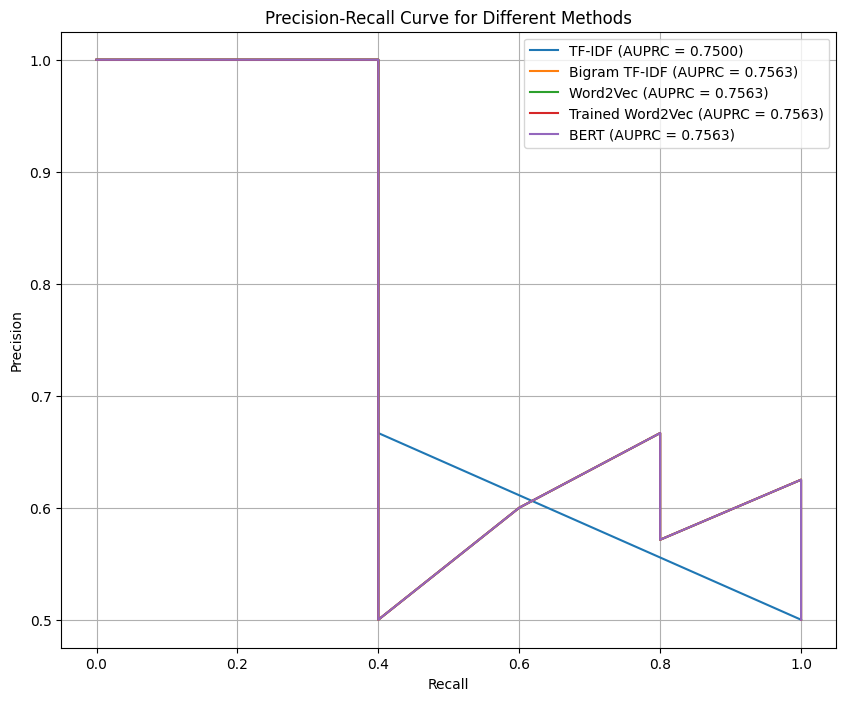

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assume ground truth is a binary relevance list (1 for relevant, 0 for not relevant)
ground_truth = np.array(corpus_relevancy_label)

# Function to calculate Precision-Recall curve and AUPRC
def plot_precision_recall_curve(ground_truth, ranking_scores, method_name):
    precision, recall, _ = precision_recall_curve(ground_truth, ranking_scores)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, label=f'{method_name} (AUPRC = {pr_auc:.4f})')

# Normalize scores if necessary
def normalize_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    if max_score == min_score:
        return [0.5 for _ in scores]  # Handle edge case where all scores are the same
    return [(score - min_score) / (max_score - min_score) for score in scores]

# Check the score distributions for each method
ranking_scores_tfidf = normalize_scores([score for _, score in rankings_tfidf])
ranking_scores_bigram = normalize_scores([score for _, score in rankings_bigram])
ranking_scores_word2vec = normalize_scores([score for _, score in rankings_word2vec])
ranking_scores_trainword2vec = normalize_scores([score for _, score in rankings_trainword2vec])
ranking_scores_bert = normalize_scores([score for _, score in rankings_bert])

# Print distributions to check the score ranges
print("TF-IDF Scores:", ranking_scores_tfidf)
print("Bigram TF-IDF Scores:", ranking_scores_bigram)
print("Word2Vec Scores:", ranking_scores_word2vec)
print("Trained Word2Vec Scores:", ranking_scores_trainword2vec)
print("BERT Scores:", ranking_scores_bert)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))

plot_precision_recall_curve(ground_truth, ranking_scores_tfidf, 'TF-IDF')
plot_precision_recall_curve(ground_truth, ranking_scores_bigram, 'Bigram TF-IDF')
plot_precision_recall_curve(ground_truth, ranking_scores_word2vec, 'Word2Vec')
plot_precision_recall_curve(ground_truth, ranking_scores_trainword2vec, 'Trained Word2Vec')
plot_precision_recall_curve(ground_truth, ranking_scores_bert, 'BERT')

# Chart settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Different Methods')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


## 💻 Assignment Submission 💻
Write your code and display the results in this Jupyter Notebook. Then, export it as an HTML file and submit both the Jupyter Notebook and the HTML file to Cyber University. </br>
**Please ensure that the code is executed and the outputs are visible when exporting the HTML file.**